## Step 1: Peak pretrain (clustering)

In this tutorial, we will introduce the peak pretraining step before applying the bridge integration, using the 10X Human PBMC data as an example. This function can also be used as a dimension reduction function independently. 

In [1]:
# !pip install --upgrade epipackpy

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

In [3]:
import epipackpy as epk

In [4]:
epk.__version__

'0.1.0dev5'

### Read data and preprocessing
First, we need to read the cell-by-peak matrix into `Anndata` structure. Since the dimension reduction is based on the binary matrix, the raw data file needs to be converted to the binary version by applying `make_binary` function. Here, we can directly read the data matrix .h5 file generated by 10X genomics Cellranger.

In [5]:
peak_1 = epk.dt.read_10x_h5("data/pbmc_batch/pbmc_10k_nextgem/atac_pbmc_10k_nextgem_filtered_peak_bc_matrix.h5")

In [6]:
peak_1 = epk.dt.make_binary(peak_1)

The raw count matrix will also be stored in the peak anndata at `layers['raw']` variable.

In [7]:
peak_1

AnnData object with n_obs × n_vars = 9688 × 144023
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'raw'

Before training the binary autoencoder, we follow the same peak filtering process as PeakVI to filter out rarely detected peaks, to make the training faster.

In [8]:
print("# regions before filtering:", peak_1.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(peak_1.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(peak_1, min_cells=min_cells)

print("# regions after filtering:", peak_1.shape[-1])

# regions before filtering: 144023
# regions after filtering: 36728


### Model training

Next, we will start training the binary autoencoder model to obtain batch-specific latent embedding. If the peak matrix is in dense matrix format, we need to input `anndata.X.todense()` to the model.

In [9]:
# model initialization
pretrain_peak_model = epk.ml.Peak_Model(count_enhancer=peak_1.X.todense())

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Model intialization completed.


In [10]:
# model training
pretrain_peak_model.train_model(nepochs=200)

Epochs: 100%|██████████| 200/200 [05:03<00:00,  1.52s/it, loss_val=4.07e+3]


### Visualizing the latent space

We can visualize the latent space before integration or any other downstream analysis. We first extract the latent embedding.

In [11]:
z = pretrain_peak_model.get_z()
peak_1.obsm['Z_epipack'] = z.detach().cpu().numpy()

Then we can cluster and visualize it by using Scanpy.

In [12]:
# dimension reduction
sc.pp.neighbors(peak_1, use_rep='Z_epipack')
sc.tl.umap(peak_1)

# clustering
sc.tl.leiden(peak_1)

/nethome/ycheng430/miniconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/nethome/ycheng430/miniconda3/envs/test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/nethome/ycheng430/miniconda3/envs/test/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


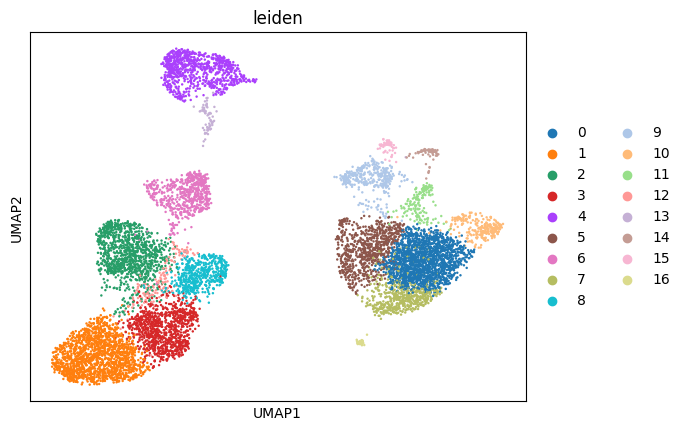

In [13]:
sc.pl.umap(peak_1, color=['leiden'])